In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 44.0 MB/s eta 0:00:00


In [ ]:
from skimage import io, color, feature
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
import mahotas as mt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing import image as keras_image
from joblib import dump, load
from tensorflow.keras.models import load_model

Set "dirPath" to data path and change working directory to "dirPath"

In [ ]:
dirPath='/content/drive/MyDrive/PlantDisease'
os.chdir(dirPath)
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  /content/drive/MyDrive/PlantDisease


Define feature extraction methods to extract shape, color, and texture features of each image

In [ ]:
def extractShape(image):
    # convert to gray
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #calculate Moments
    moments = cv2.moments(gray_image)
    #calculate Hu Moments
    huMoments = cv2.HuMoments(moments)
    # convert huMoments to logarithmic scale for easier comparision
    for i in range(7):
        huMoments[i] = -1 * np.copysign(1.0, huMoments[i]) * np.log10(abs(huMoments[i]))
    # Convert huMoments to row vector for eaiser storage with other extracted features
    huMoments = huMoments.flatten()
    return huMoments
def extractHaralick(image): # texture features
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    textures = mt.features.haralick(image).mean(axis=0)
    return textures
def extract_color_histogram(image):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the histogram for each channel
    blue_color = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    red_color = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    green_color = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])

    # Concatenate histograms into a single feature vector
    hist_features = np.concatenate((blue_color, red_color, green_color), axis=None)

    return hist_features

In [ ]:
PlantVillage = 'PlantVillage'

Process images and extract features and save them in an array with their corresponding labels

In [ ]:
features = []
labels = []
for subfolder in os.listdir(PlantVillage):
    if subfolder.startswith('Tomato') or subfolder.startswith('tomato'):
        folder_path = os.path.join(PlantVillage, subfolder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                image = cv2.imread(image_path)
                if image is None:  # If the image couldn't be loaded
                    print(f"Failed to load image: {image_path}. Skipping...")
                    continue  # Skip the rest of the code in this loop iteration and proceed with the next image
                # If the image is loaded successfully, proceed with processing
                hist_features = extract_color_histogram(image)
                hu_moments = extractShape(image)
                haralick_features = extractHaralick(image)
                combined_features = np.concatenate((hist_features, hu_moments, haralick_features), axis=None)
                features.append(combined_features)
                labels.append(subfolder)

Failed to load image: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c. Skipping...


In [ ]:
features = np.array(features)
labels = np.array(labels)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

In [ ]:
# Save
dump(X_train, 'X_train.joblib')
dump(X_test, 'X_test.joblib')
dump(y_train, 'y_train.joblib')
dump(y_test, 'y_test.joblib')

['y_test.joblib']

In [ ]:
# Load
X_train = load('X_train.joblib')
X_test = load('X_test.joblib')
y_train = load('y_train.joblib')
y_test = load('y_test.joblib')

Decision Tree Model

In [ ]:
# Decision Tree Algorithim
# Initialize the decision tree classifier
DTC = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=None)

# Fit the model to the training data
DTC.fit(X_train, y_train)

# save model
dump(DTC, 'decision_tree_model.joblib')

# Make predictions on the test set
y_pred = DTC.predict(X_test)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of descion tree model: {accuracy}")

Accuracy of descion tree model: 0.8242990654205608


In [ ]:
DTC_loaded = load('decision_tree_model.joblib')
y_pred_dt = DTC_loaded.predict(X_test)
print("Accuracy of Decision Tree model:", accuracy_score(y_test, y_pred_dt))

Accuracy of Decision Tree model: 0.8242990654205608


Random Forest Model

In [ ]:
#Random Forest Algorithm

# Initialize the random forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# save model
dump(rf_classifier, 'random_forest_model.joblib')

# Predict the labels for the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest:", accuracy)

Accuracy of Random Forest: 0.9520249221183801


In [ ]:
rf_classifier_loaded = load('random_forest_model.joblib')
y_pred_rf = rf_classifier_loaded.predict(X_test)
print("Accuracy of Random Forest model:", accuracy_score(y_test, y_pred_rf))

Accuracy of Random Forest model: 0.9520249221183801


SVM Model

In [ ]:
#Support Vector Machine Algorithm

# Initialize the Support Vector Machine classifier
svm_classifier = SVC()

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Save the SVM model
dump(svm_classifier, 'svm_model.joblib')

# Predict the labels for the test set
y_pred = svm_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Support Vector Machine:", accuracy)

Accuracy of Support Vector Machine: 0.9389408099688473


In [ ]:
svm_classifier_loaded = load('svm_model.joblib')
y_pred_svm = svm_classifier_loaded.predict(X_test)
print("Accuracy of SVM model:", accuracy_score(y_test, y_pred_svm))

Accuracy of SVM model: 0.9389408099688473


Logistic Regression Model

In [ ]:
# Scaling features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.1, random_state=42)

dump((X_train, X_test, y_train, y_test), 'train_test_data.joblib')

['train_test_data.joblib']

In [ ]:
# Load scaled training and testing data
X_train, X_test, y_train, y_test = load('train_test_data.joblib')

In [ ]:
# Initialize the logistic regression classifier
logreg = LogisticRegression(max_iter=10000)  # Increase max_iter if needed

# Fit the model to the training data
logreg.fit(X_train, y_train)

# Save the Logistic Regression model
dump(logreg, 'logistic_regression_model.joblib')

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(
    f"Accuracy of logistic regression: {accuracy}")


Accuracy of logistic regression: 0.9320872274143303


In [ ]:
logreg_loaded = load('logistic_regression_model.joblib')
y_pred_logreg = logreg_loaded.predict(X_test)
print("Accuracy of logistic regression model:", accuracy_score(y_test, y_pred_logreg))

Accuracy of logistic regression model: 0.9320872274143303


Define a function to add guassian noise

In [ ]:
def add_gaussian_noise(image):
    # Set the mean and standard deviation of the Gaussian noise
    mean = 0
    sigma = 50
    # Extract the dimensions of the image
    row, col, ch = image.shape
    # Generate Gaussian noise, matching the image dimensions
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    # Reshape the noise array to match the image structure
    gauss = gauss.reshape(row, col, ch)
    # Add the Gaussian noise to the original image
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

Process images again and plot original image and noisy image

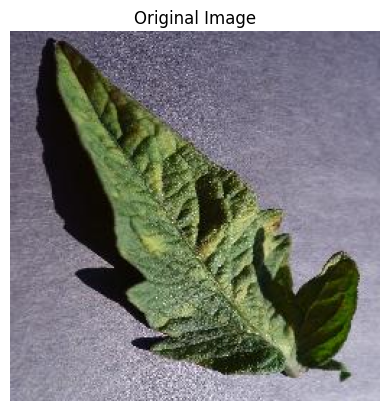

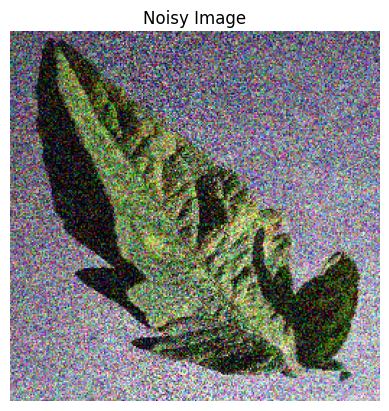

In [ ]:
# Iterate images, and add noise
for subfolder in os.listdir(PlantVillage):
    if subfolder.startswith('Tomato') or subfolder.startswith('tomato'):
        folder_path = os.path.join(PlantVillage, subfolder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Failed to load image: {image_path}. Skipping...")
                    continue
                noisy_image = add_gaussian_noise(image)
                # Plot the image to see before/after noise gets add to image
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.title('Original Image')
                plt.show()
                # Plot the noisy image
                plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.title('Noisy Image')
                plt.show()
                # Exit the loop after reading one image
                break
            break

Add noise to each image, and extract features of noisy images

In [ ]:
features2 = []
labels2 = []
for subfolder in os.listdir(PlantVillage):
    if subfolder.startswith('Tomato') or subfolder.startswith('tomato'):
        folder_path = os.path.join(PlantVillage, subfolder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                image = cv2.imread(image_path)
                if image is None:  # If the image couldn't be loaded
                    print(f"Failed to load image: {image_path}. Skipping...")
                    continue  # Skip the rest of the code in this loop iteration and proceed with the next image
                # If the image is loaded successfully, proceed with processing
                # Add Gaussian noise to the image
                noisy_image = add_gaussian_noise(image)
                # Extract features (assuming extractShape is a predefined function)
                hist_features = extract_color_histogram(noisy_image)
                hu_moments = extractShape(noisy_image)
                haralick_features = extractHaralick(noisy_image)
                combined_features = np.concatenate((hist_features, hu_moments, haralick_features), axis=None)
                features2.append(combined_features)
                labels2.append(subfolder)

Failed to load image: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c. Skipping...


In [ ]:
features2 = np.array(features2)
labels2 = np.array(labels2)

In [ ]:
# Split the dataset into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, labels2, test_size=0.1, random_state=42)

In [ ]:
# Save the training and testing datasets
dump(X_train2, 'X_train2.joblib')
dump(X_test2, 'X_test2.joblib')
dump(y_train2, 'y_train2.joblib')
dump(y_test2, 'y_test2.joblib')

['y_test2.joblib']

In [ ]:
# Load
X_train2 = load('X_train2.joblib')
X_test2 = load('X_test2.joblib')
y_train2 = load('y_train2.joblib')
y_test2 = load('y_test2.joblib')

Decision Tree Model after adding Noise

In [ ]:
# Decision Tree

# Initialize the decision tree classifier
DTC = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=None)

# Fit the model to the training data
DTC.fit(X_train2, y_train2)

# save model
dump(DTC, 'decision_tree_model2.joblib')

# Make predictions on the test set
y_pred = DTC.predict(X_test2)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test2, y_pred)
print(f"Accuracy of descion tree model: {accuracy}")

Accuracy of descion tree model: 0.6641744548286604


In [ ]:
DTC_loaded2 = load('decision_tree_model2.joblib')
y_pred_dt2 = DTC_loaded2.predict(X_test2)
print("Accuracy of Decision Tree model after adding noise:", accuracy_score(y_test2, y_pred_dt2))

Accuracy of Decision Tree model after adding noise: 0.6641744548286604


Random Forest Model after adding Noise

In [ ]:
# Random Forest Algorithm
# Initialize the random forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier on the training data
rf_classifier.fit(X_train2, y_train2)

# save model
dump(rf_classifier, 'random_forest_model2.joblib')

# Predict the labels for the test set
y_pred = rf_classifier.predict(X_test2)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test2, y_pred)
print("Accuracy of Random Forest:", accuracy)

Accuracy of Random Forest: 0.7682242990654206


In [ ]:
rf_classifier_loaded2 = load('random_forest_model2.joblib')
y_pred_rf2 = rf_classifier_loaded2.predict(X_test2)
print("Accuracy of Random Forest model:", accuracy_score(y_test2, y_pred_rf2))

Accuracy of Random Forest model: 0.7682242990654206


SVM model after adding Noise

In [ ]:
#Support Vector Machine Algorithm
# Initialize the Support Vector Machine classifier
svm_classifier = SVC()

# Train the classifier on the training data
svm_classifier.fit(X_train2, y_train2)

# Save the SVM model
dump(svm_classifier, 'svm_model2.joblib')

# Predict the labels for the test set
y_pred = svm_classifier.predict(X_test2)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test2, y_pred)
print("Accuracy of Support Vector Machine:", accuracy)

Accuracy of Support Vector Machine: 0.6610591900311527


In [ ]:
svm_classifier_loaded2 = load('svm_model2.joblib')
y_pred_svm2 = svm_classifier_loaded2.predict(X_test2)
print("Accuracy of SVM model:", accuracy_score(y_test2, y_pred_svm2))

Accuracy of SVM model: 0.6610591900311527


Logistic Regression Model after adding Noise

In [ ]:
scaler = StandardScaler()
features_scaled2 = scaler.fit_transform(features2)

# Split the dataset into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    features_scaled2, labels2, test_size=0.2, random_state=42)
# save
dump((X_train2, X_test2, y_train2, y_test2), 'train_test_data2.joblib')

['train_test_data2.joblib']

In [ ]:
# Load scaled training and testing data
X_train2, X_test2, y_train2, y_test2 = load('train_test_data2.joblib')

In [ ]:
# Initialize the logistic regression classifier
logreg = LogisticRegression(max_iter=10000)  # Increase max_iter if needed

# Fit the model to the training data
logreg.fit(X_train2, y_train2)

# Save the Logistic Regression model
dump(logreg, 'logistic_regression_model2.joblib')

# Make predictions on the test set
y_pred = logreg.predict(X_test2)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test2, y_pred)
print(
    f"Accuracy of logistic regression model: {accuracy}")

Accuracy of logistic regression model: 0.7198504206918043


In [ ]:
logreg_loaded2 = load('logistic_regression_model2.joblib')
y_pred_logreg2 = logreg_loaded2.predict(X_test2)
print("Accuracy of logistic regression model:", accuracy_score(y_test2, y_pred_logreg2))

Accuracy of logistic regression model: 0.7198504206918043


Process image labels and paths for deep learning

In [ ]:
# Deep Learning

# Initialize lists to store features and labels
filepaths = []
labels = []

# append filepaths of each image and their labels
for subfolder in os.listdir(PlantVillage):
    if subfolder.lower().startswith('tomato'):
        folder_path = os.path.join(PlantVillage, subfolder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)

                filepaths.append(image_path)
                labels.append(subfolder)

# Convert filepaths and labels to numpy arrays
filepaths = np.array(filepaths)
labels = np.array(labels)

In [ ]:
# Create a DataFrame to store filepaths and labels
df = pd.DataFrame({'Filepaths': filepaths, 'Labels': labels})

print(df.head())
print(df.shape)

                                           Filepaths            Labels
0  PlantVillage/Tomato_Leaf_Mold/b625a517-f750-41...  Tomato_Leaf_Mold
1  PlantVillage/Tomato_Leaf_Mold/51189dab-468d-43...  Tomato_Leaf_Mold
2  PlantVillage/Tomato_Leaf_Mold/74fdc5c4-bb48-47...  Tomato_Leaf_Mold
3  PlantVillage/Tomato_Leaf_Mold/9afdf72c-5e19-40...  Tomato_Leaf_Mold
4  PlantVillage/Tomato_Leaf_Mold/cf7d8916-0dc4-46...  Tomato_Leaf_Mold
(16044, 2)


Labels
Tomato__Tomato_YellowLeaf__Curl_Virus          3220
Tomato_Bacterial_spot                          2128
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1611
Tomato__Target_Spot                            1404
Tomato_Early_blight                            1000
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Name: count, dtype: int64


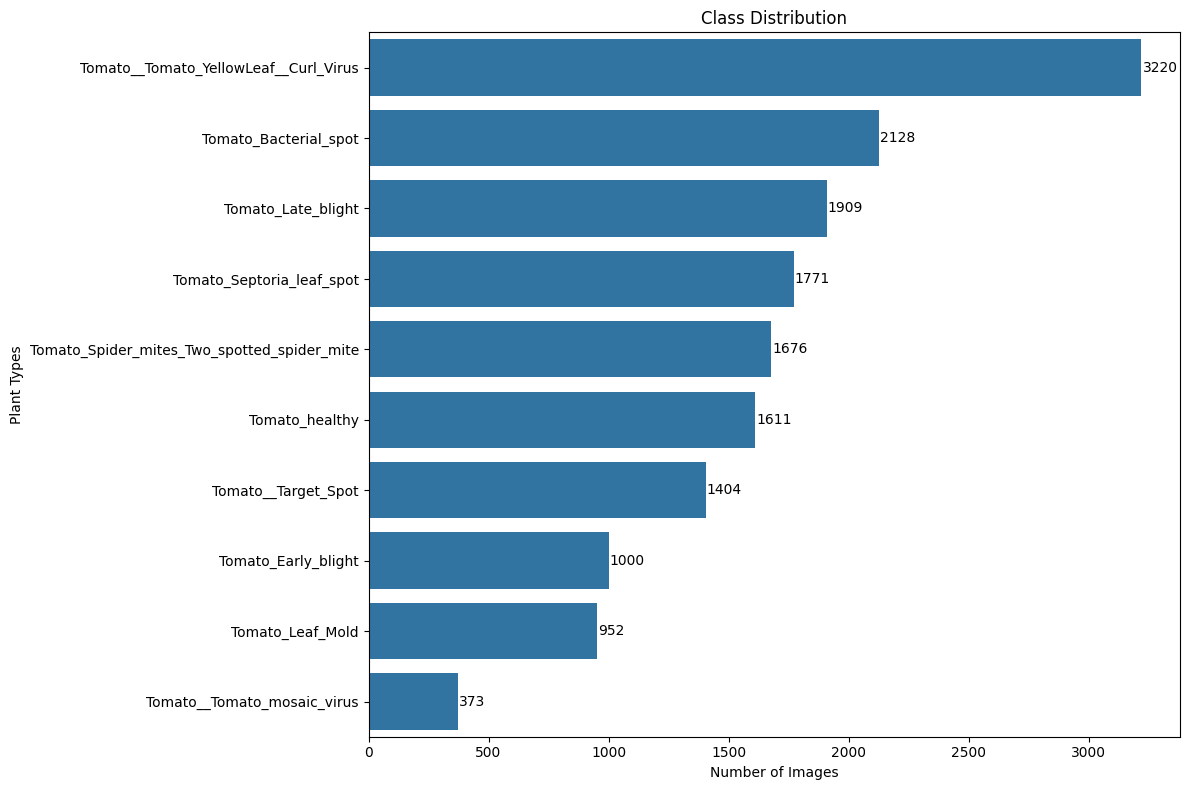

In [ ]:
# Count the number of images in each class
class_counts = df['Labels'].value_counts()
print(class_counts)

# Visualize class distribution using a horizontal bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=class_counts.values, y=class_counts.index, orient='h')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Plant Types')
plt.tight_layout()

# Add data labels to each bar
for i, v in enumerate(class_counts.values):
    ax.text(v + 5, i, str(v), color='black', va='center')


plt.show()

Deep Learning Model

In [ ]:
# Split the data into training and test sets (80% training, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Saving the test DataFrame to a CSV file after creating it
test_df.to_csv('test_paths_labels.csv', index=False)
# Split the training data into training and validation sets (80% training, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Generate images from dataframe
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False,
    seed=42
)

test_generator =  test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False,
    seed=42
)

# Generic Model Creation### AVG pool
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Training Model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x=train_generator,
    validation_data=valid_generator,
    epochs=5,
    verbose=1,
    validation_steps=None,
    shuffle=False
)

# Save the model
model.save('dl_model.h5')

# Test (AVG POOL & epochs=1 0) %99.1
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

Found 10268 validated image filenames belonging to 10 classes.
Found 2567 validated image filenames belonging to 10 classes.
Found 3208 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepaths". These filename(s) will be ignored.
  warnings.warn(


83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/5
321/321 [==============================] - 287s 784ms/step - loss: 0.4393 - accuracy: 0.8651 - val_loss: 0.3910 - val_accuracy: 0.9455
Epoch 2/5
321/321 [==============================] - 247s 770ms/step - loss: 0.1134 - accuracy: 0.9662 - val_loss: 0.0675 - val_accuracy: 0.9790
Epoch 3/5
321/321 [==============================] - 241s 749ms/step - loss: 0.0697 - accuracy: 0.9769 - val_loss: 0.0459 - val_accuracy: 0.9871
Epoch 4/5
321/321 [==============================] - 238s 739ms/step - loss: 0.0546 - accuracy: 0.9850 - val_loss: 0.0433 - val_accuracy: 0.9868
Epoch 5/5
321/321 [==============================] - 242s 754ms/step - loss: 0.0484 - accuracy: 0.9852 - val_loss: 0.1030 - val_accuracy: 0.9766


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 20s 194ms/step - loss: 0.0991 - accuracy: 0.9757
Test Accuracy: 0.9756857752799988


In [ ]:
# Load the test DataFrame from the CSV file
test_df = pd.read_csv('test_paths_labels.csv')

# Recreate the ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Recreate the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False,
    seed=42
)

# Load the deep learning model
model_loaded = load_model('dl_model.h5')

# Evaluate the loaded model
test_loss, test_accuracy = model_loaded.evaluate(test_generator)
print("Test Accuracy from loaded model:", test_accuracy)


Found 3208 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Filepaths". These filename(s) will be ignored.
  warnings.warn(


101/101 [==============================] - 883s 9s/step - loss: 0.0991 - accuracy: 0.9757
Test Accuracy from loaded model: 0.9756857752799988
